## Loading of Steinmetz data

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Data loading
import numpy as np
from matplotlib import pyplot as plt

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[25]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [3]:
for i in range(len(alldat)):
  print(i)
  print(alldat[i]['mouse_name'])
  L = len(alldat[i]['feedback_type'])
  R = sum(alldat[i]['feedback_type'])
  nr = (R + L) * 1.0/ 2
  print('number of trials = ' , L )
  print('number rewarded = ' , nr)
  print('fraction  rewarded= ',  nr * 1.0 / L  )




0
Cori
number of trials =  214
number rewarded =  141.0
fraction  rewarded=  0.6588785046728972
1
Cori
number of trials =  251
number rewarded =  159.0
fraction  rewarded=  0.6334661354581673
2
Cori
number of trials =  228
number rewarded =  151.0
fraction  rewarded=  0.6622807017543859
3
Forssmann
number of trials =  249
number rewarded =  166.0
fraction  rewarded=  0.6666666666666666
4
Forssmann
number of trials =  254
number rewarded =  168.0
fraction  rewarded=  0.6614173228346457
5
Forssmann
number of trials =  290
number rewarded =  215.0
fraction  rewarded=  0.7413793103448276
6
Forssmann
number of trials =  252
number rewarded =  169.0
fraction  rewarded=  0.6706349206349206
7
Hench
number of trials =  250
number rewarded =  161.0
fraction  rewarded=  0.644
8
Hench
number of trials =  372
number rewarded =  255.0
fraction  rewarded=  0.6854838709677419
9
Hench
number of trials =  447
number rewarded =  277.0
fraction  rewarded=  0.6196868008948546
10
Hench
number of trials =  3

In [4]:



import numpy as np
import numba as nb
from scipy import integrate
from numba import jit

from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

@jit(nopython=True)
def conditional_probability(y_l, y_r, x_l, x_r, sigma):
  return np.exp(-((y_l- x_l)**2 + (y_r - x_r)**2 ) / 2 * sigma**2 )

@jit(nopython=True)
def bayesian_mouse(sigma, frequency, y_l, y_r):
  contrast = [0,0.25, 0.5, 1]
  prior = frequency
  numerator = np.zeros(16).reshape(4,4)
  for i in range(4):
    for j in range(4):
      x_l= contrast[i]
      x_r = contrast[j]
      numerator[i,j] = prior[i,j] * conditional_probability(y_l, y_r, x_l, x_r, sigma)
  denominator = np.sum(numerator)

  posterior =  numerator / denominator

  return (posterior)

@jit(nopython=True)
def check(posterior):
  return (np.sum(posterior))


@jit(nopython=True)
def expected_gain(posterior, energy_loss):
  a0 = 0
  ap1 = 0
  am1 = 0
  
  a0 = posterior[0,0] + energy_loss 
  for i in range(1,4):
    ap1 += posterior[i,i] / 2
    am1 += posterior[i,i] / 2
    for j in range(i):
      ap1 += posterior[i,j]
      am1 += posterior[j,i]
  return np.array([am1, a0, ap1] )


@jit(nopython=True)
def action_choice(gains):
  return np.argmax(gains) 



@jit(nopython=True)
def eps_greedy(gains, epsilon):
  p = np.random.rand()
  if (p > epsilon):
    return np.argmax(gains)
  else:
    return np.random.randint(3)


@jit(nopython=True)  
def prediction(sigma, frequency, x_l, x_r): 
  y_l = x_l + np.random.normal(0,sigma)
  y_r = x_r + np.random.normal(0,sigma)
  posterior = bayesian_mouse(sigma, frequency, y_l, y_r)
  gains = expected_gain(posterior)
  response = action_choice(gains)
  return(response)


@jit(nopython=True)  
def prediction_corr(sigma, eta, frequency, x_l, x_r, energy_loss):
  corrnoise = np.random.normal(0, eta )  
  y_l = x_l + np.random.normal(0,sigma ) + corrnoise
  y_r = x_r + np.random.normal(0,sigma) + corrnoise
  posterior = bayesian_mouse(sigma, frequency, y_l, y_r)
  gains = expected_gain(posterior, energy_loss)
  response = action_choice(gains)
  return(response)




@jit(nopython=True)  
def prediction_eps(sigma, frequency, x_l, x_r, epsilon):
  y_l = x_l + np.random.normal(0,sigma)
  y_r = x_r + np.random.normal(0,sigma)
  posterior = bayesian_mouse(sigma, frequency, y_l, y_r)
  gains = expected_gain(posterior)
  response = eps_greedy(gains, epsilon)
  return(response)


def integrated_conditional_probability(A,x_decided, x_input):
  factor = A @ (x_decided - x_input)
  return np.exp(-np.sum(factor**2))


def integrated_bayesian(A, frequency, x_decided):
  contrast = [0,0.25, 0.5, 1]
  prior = frequency
  numerator = np.zeros(16).reshape(4,4)
  x_input = np.zeros(2) 
  for i in range(4):
    for j in range(4):
      x_input[0]= contrast[i]
      x_input[1] = contrast[j]
      numerator[i,j] = prior[i,j] * integrated_conditional_probability(A,x_decided, x_input)

   

  return (numerator)

def expected_gain_linear(posterior, energy_loss):
  a0 = 0
  ap1 = 0
  am1 = 0
  
  a0 = posterior[0,0] + energy_loss 
  for i in range(1,4):
    ap1 += posterior[i,i] / 2
    am1 += posterior[i,i] / 2
    for j in range(i):
      ap1 += posterior[i,j]
      am1 += posterior[j,i]
  return np.array([am1, a0, ap1] )

def unnormalized_probability_choice(gain):
  return gain



def analytical_linear_choice(A, frequency, energy_loss):  #returns likelihood
  contrast = [0,0.25, 0.5, 1]
  likel = np.zeros(48).reshape(4,4,3)
  choice = np.zeros(48).reshape(4,4,3)
  x_decided = np.zeros(2)
  for i in range(4):
    for j in range(4):
      x_decided[0] = contrast[i]
      x_decided[1] = contrast[j]
      posterior = integrated_bayesian(A, frequency, x_decided)
      choice[i,j,:] = expected_gain_linear(posterior, energy_loss)
  for i in range(3):
    likel[:,:,i] = choice[:,:, i] / np.sum(choice, axis = 2)[:,:]
  return(likel)



@jit(nopython=True)
def liklihood(sigma, frequency, n_trials):
  contrast = [0,0.25, 0.5, 1]
  likel = np.zeros(48).reshape(4,4,3)
  for i in range(4):
    for j in range(4):
      for k in range(n_trials):
        x_l = contrast[i]
        x_r = contrast[j]
        response = prediction(sigma, frequency, x_l, x_r)
        likel[i,j,int(response)] += 1
  likel /= n_trials

  return likel

@jit(nopython=True)
def liklihood_corr(sigma, eta, frequency, n_trials, energy_loss):
  contrast = [0,0.25, 0.5, 1]
  likel = np.zeros(48).reshape(4,4,3)
  for i in range(4):
    for j in range(4):
      for k in range(n_trials):
        x_l = contrast[i]
        x_r = contrast[j]
        response = prediction_corr(sigma, eta,  frequency, x_l, x_r, energy_loss)
        likel[i,j,int(response)] += 1
  likel /= n_trials

  return likel



def mat_loglikelihood(likel, pmatr):
  lglike = np.zeros(48).reshape(4,4,3)
  newlike = np.zeros(48).reshape(4,4,3)
  for i in range(4):
    for j in range(4):
      newlike[i,j,:] = pmatr @ likel[i,j,:]
  for i in range(4):
    for j in range(4):
      for k in range(3):
        if (newlike[i,j,k] > 0):
          lglike[i,j,k] = np.log(newlike[i,j,k])
        else:
          lglike[i,j,k] = -1000

  return lglike


@jit(nopython=True)
def linear_loglikelihood(likel, eps):
  shift = np.ones(48).reshape(4,4,3)
  lglike = np.zeros(48).reshape(4,4,3)
  likel = (1 - eps)*likel + (eps / 3) * shift
  for i in range(4):
    for j in range(4):
      for k in range(3):
        if (likel[i,j,k] > 0):
          lglike[i,j,k] = np.log(likel[i,j,k])
        else:
          lglike[i,j,k] = -1000

  return lglike
  


def linear_discrepancy_as_func(inputvec, real_probs, frequency):
  energy_loss = inputvec[0]
  A = inputvec[1:5].reshape(2,2)
  pmatr = inputvec[5:].reshape(3,3)
  likel = analytical_linear_choice(A, frequency, energy_loss)
  lgl = - mat_loglikelihood(likel, pmatr)
  disc = np.sum(real_probs * lgl)


  return(disc)



def discrepancy_as_func(eps, likes, real_probs):
  a,b,c,d = likes.shape
  disc = np.zeros(a)
  for i in range(a):
    likel = likes[i,:,:,:]
    lgl = -linear_loglikelihood(likel, eps)
    disc[i] = np.sum(real_probs * lgl)

  return(np.min(disc))


def matr_discrepancy_as_func(pvec, likes, real_probs):
  pmatr = pvec.reshape(3,3)
  a,b,c,d,e = likes.shape
  disc = np.zeros(a*b).reshape(a,b)
  for i in range(a):
    for j in range(b):
      likel = likes[i,j,:,:]
      lgl = - mat_loglikelihood(likel, pmatr)
      disc[i,j] = np.sum(real_probs * lgl)

  return(np.min(disc))





@jit(nopython=True)
def loglikelihood(sigma, frequency, n_trials):
  contrast = [0,0.25, 0.5, 1]
  lglike = np.zeros(48).reshape(4,4,3)
  for i in range(4):
    for j in range(4):
      for k in range(n_trials):
        x_l = contrast[i]
        x_r = contrast[j]
        response = prediction(sigma, frequency, x_l, x_r)
        lglike[i,j,int(response)] += 1
  lglike /= n_trials
  for i in range(4):
    for j in range(4):
      for k in range(3):
        if (lglike[i,j,k] > 0):
          lglike[i,j,k] = np.log(lglike[i,j,k])
        else:
          lglike[i,j,k] = -1000
  return lglike

@jit(nopython=True)
def loglikelihood_eps(sigma, frequency, n_trials, epsilon):
  contrast = [0,0.25, 0.5, 1]
  lglike = np.zeros(48).reshape(4,4,3)
  for i in range(4):
    for j in range(4):
      for k in range(n_trials):
        x_l = contrast[i]
        x_r = contrast[j]
        response = prediction_eps(sigma, frequency, x_l, x_r, epsilon)
        lglike[i,j,int(response)] += 1
  lglike /= n_trials
  for i in range(4):
    for j in range(4):
      for k in range(3):
        if (lglike[i,j,k] > 0):
          lglike[i,j,k] = np.log(lglike[i,j,k])
        else:
          lglike[i,j,k] = -1000
  return lglike



@jit(nopython=True)
def real_results(vec_left, vec_right, response):
  resp_prob_table = np.zeros(48).reshape(4,4,3)
  ind_left = contrast_to_index(vec_left)
  ind_right = contrast_to_index(vec_right)
  for k in range(len(vec_left)):
    resp_prob_table[int(ind_left[k]),int(ind_right[k]), int(response[k])+1] += 1
  return (resp_prob_table)




 
@jit(nopython=True)
def contrast_to_index(vec):
  ind = np.zeros(len(vec))
  for i in range(len(vec)):
    if (vec[i] == 0):
      ind[i] = 0
    elif (vec[i] == 0.25):
      ind[i] = 1
    elif (vec[i] == 0.5):
      ind[i] = 2
    elif (vec[i] == 1):
      ind[i] = 3
  return ind     

@jit(nopython=True)
def frequency_matr(vec_left, vec_right):
  F = np.zeros(16).reshape(4,4)
  ind_left = contrast_to_index(vec_left)
  ind_right = contrast_to_index(vec_right)
  for i in range(len(vec_left)):
    F[int(ind_left[i]),int(ind_right[i])] += 1
  F /= len(vec_left)
  return(F)

  






In [5]:
R = 0
L = 0
skewdness = {}
skewdness['nogo'] = []
skewdness['rand'] = []
skewdness['rp1'] = []
skewdness['rp2'] = []
skewdness['all'] = []
for i in range(39):
  print(i)
  dat = alldat[i]
  print(dat['mouse_name'])
  vec_left = dat['contrast_left']
  vec_right = dat['contrast_right']
  F = frequency_matr(vec_left, vec_right)

#  print(F)
  response = dat['response']

  
  real_probs = real_results(vec_left, vec_right, response)
  skewdness['all'].append(real_probs)
  #print(real_probs)

  r = 0
  l = 0
  for i in range(4):
    for j in range(i):
      r = r + F[i,j]
      l = l + F[j,i]

 # print('r = ',r)
 # print('l=',l)
  #sk = (r-l) / (r +l)
  #print('sk =',sk)
  R += r
  L += l
  nogo_skew = real_probs[0,0,:]
  print(nogo_skew)
  skewdness['nogo'].append(nogo_skew)
  rand_skew = np.zeros(3)
  for j in range(3):
    rand_skew += real_probs[j+1, j+1, : ]
  #print(rp)
  skewdness['rand'].append(rand_skew)
  rp1 = np.zeros(3)
  rp2 = np.zeros(3)
  
  for j in range(4):
    for k in range(j):
      rp1 += real_probs[j,k, :]
      rp2 += real_probs[k,j, :]
  skewdness['rp1'].append(rp1)
  skewdness['rp2'].append(rp2)
  print(rp1)
  print(rp2)


  #print(rp1)
  #print(rp2)

  #for j in range(3):
  #  print(real_probs[:,:,j]) 


#print(R)
#print(L)
#print((R-L)/(R + L)) 

0
Cori
[ 8. 34.  4.]
[ 1.  9. 51.]
[52. 29. 14.]
1
Cori
[13. 47.  6.]
[ 7. 15. 57.]
[46. 31.  8.]
2
Cori
[20. 47.  9.]
[ 4.  7. 35.]
[57. 22.  5.]
3
Forssmann
[ 5. 61.  2.]
[ 5. 35. 44.]
[55. 23.  2.]
4
Forssmann
[12. 53.  6.]
[ 7. 30. 39.]
[62. 18.  3.]
5
Forssmann
[10. 62.  7.]
[15. 21. 64.]
[77.  7.  6.]
6
Forssmann
[26. 48. 15.]
[18.  3. 50.]
[63. 10.  6.]
7
Hench
[ 2. 31.  8.]
[ 3. 32. 74.]
[49. 26.  9.]
8
Hench
[ 6. 57. 13.]
[  4.  47. 120.]
[72. 25.  8.]
9
Hench
[15. 71. 27.]
[ 11.  41. 127.]
[66. 34. 22.]
10
Hench
[12. 66.  4.]
[  4.  14. 105.]
[89. 16.  7.]
11
Lederberg
[40. 50. 18.]
[ 5.  1. 97.]
[89. 13.  9.]
12
Lederberg
[20. 47. 15.]
[  3.   7. 102.]
[81.  2.  8.]
13
Lederberg
[31. 44. 10.]
[ 6. 16. 66.]
[71.  1. 11.]
14
Lederberg
[36. 71. 10.]
[  6.  15. 119.]
[109.  11.  10.]
15
Lederberg
[27. 48.  3.]
[ 7. 22. 78.]
[68.  3. 11.]
16
Lederberg
[14. 39.  0.]
[ 4.  2. 66.]
[73. 11.  3.]
17
Lederberg
[24. 60. 10.]
[ 7. 12. 92.]
[89.  4.  5.]
18
Moniz
[ 5. 37.  6.]
[ 5. 29. 5

In [6]:
for i in range(39):
  dat = alldat[i]
  print(i, "    ", dat['mouse_name'], "    ", skewdness['nogo'][i] , skewdness['all'][i][0,3,:] , skewdness['all'][i][3,0,:]  )

0      Cori      [ 8. 34.  4.] [17.  3.  1.] [ 0.  1. 17.]
1      Cori      [13. 47.  6.] [17. 20.  5.] [ 0.  4. 18.]
2      Cori      [20. 47.  9.] [19. 14.  1.] [ 0.  0. 12.]
3      Forssmann      [ 5. 61.  2.] [12.  2.  0.] [0. 8. 5.]
4      Forssmann      [12. 53.  6.] [15.  4.  0.] [ 1.  3. 10.]
5      Forssmann      [10. 62.  7.] [16.  0.  0.] [ 1.  3. 15.]
6      Forssmann      [26. 48. 15.] [10.  0.  0.] [0. 0. 6.]
7      Hench      [ 2. 31.  8.] [19. 10.  2.] [ 0.  3. 30.]
8      Hench      [ 6. 57. 13.] [23. 12.  0.] [ 0. 16. 36.]
9      Hench      [15. 71. 27.] [22. 10.  5.] [ 4. 17. 54.]
10      Hench      [12. 66.  4.] [29.  0.  1.] [ 0.  1. 36.]
11      Lederberg      [40. 50. 18.] [22. 13.  0.] [ 0.  0. 21.]
12      Lederberg      [20. 47. 15.] [22.  1.  0.] [ 0.  0. 21.]
13      Lederberg      [31. 44. 10.] [17.  0.  0.] [ 0.  3. 16.]
14      Lederberg      [36. 71. 10.] [33.  3.  0.] [ 0.  1. 29.]
15      Lederberg      [27. 48.  3.] [18.  0.  0.] [ 0.  0. 18.]
16     

NameError: ignored

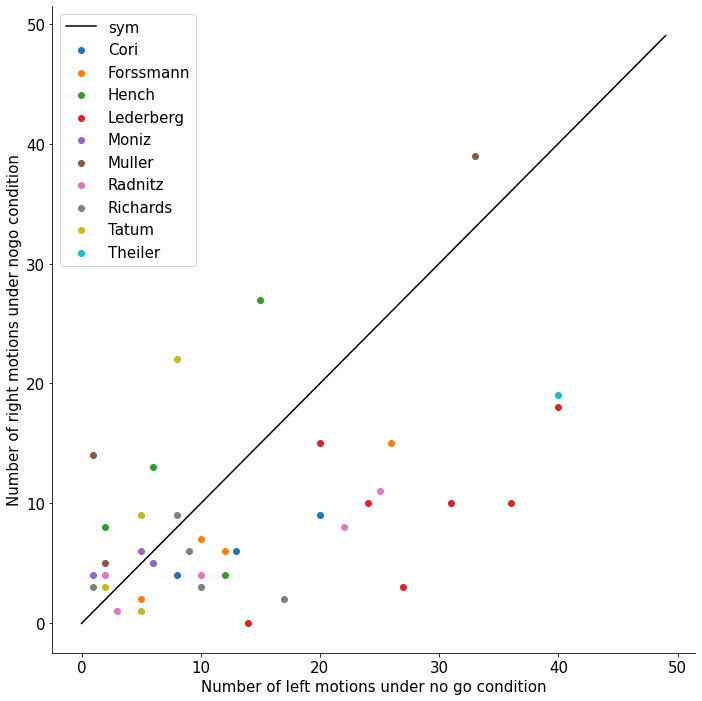

In [7]:
rcParams['figure.figsize'] = [10, 10]

mice = {}

for i in range(39):
  mice[alldat[i]['mouse_name']] = {}


for i in range(39):
  mice[alldat[i]['mouse_name']]['responses'] = []
  



for i in range(39):
  mice[alldat[i]['mouse_name']]['responses'].append(skewdness['all'][i])


fig, ax = plt.subplots()
for key in mice.keys():
  n = len(mice[key]['responses'])
  vec_0_l = np.zeros(n)
  vec_0_r = np.zeros(n)
  for i in range(n):
    vec_0_l[i] = mice[key]['responses'][i][0,0,0]
    vec_0_r[i] = mice[key]['responses'][i][0,0,2]
  mice[key]['vec_0_l'] = vec_0_l
  mice[key]['vec_0_r'] = vec_0_r

  ax.scatter(vec_0_l, vec_0_r, label = key)
  
line_x = np.arange(50)
line_y = np.arange(50)

ax.plot(line_x, line_y, 'k',label = 'sym')
ax.set_xlabel("Number of left motions under no go condition")
ax.set_ylabel("Number of right motions under nogo condition")  
legend  = ax.legend()

plt.savefig("Nogo.pdf")
files.download("Nogo.pdf")


#print(mice)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

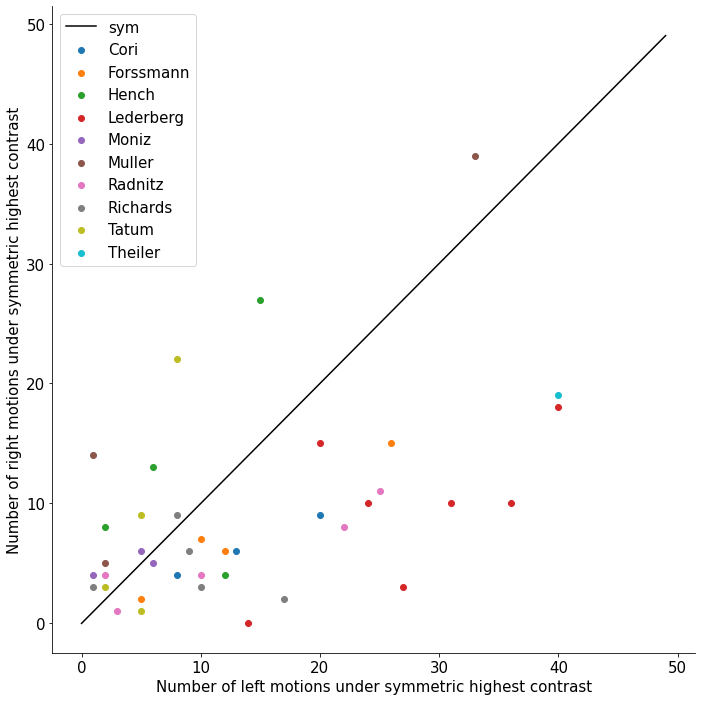

In [17]:
from google.colab import files

fig, ax = plt.subplots()
for key in mice.keys():
  n = len(mice[key]['responses'])
  vec_0_l = np.zeros(n)
  vec_0_r = np.zeros(n)
  for i in range(n):
    vec_0_l[i] = mice[key]['responses'][i][0,0,0]
    vec_0_r[i] = mice[key]['responses'][i][0,0,2]
  mice[key]['vec_0_l'] = vec_0_l
  mice[key]['vec_0_r'] = vec_0_r

  ax.scatter(vec_0_l, vec_0_r, label = key)
  
line_x = np.arange(50)
line_y = np.arange(50)

ax.plot(line_x, line_y, 'k',label = 'sym')
ax.set_xlabel("Number of left motions under symmetric highest contrast")
ax.set_ylabel("Number of right motions under symmetric highest contrast")  
legend  = ax.legend()

plt.savefig("contrast-0.pdf")
files.download("contrast-0.pdf")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

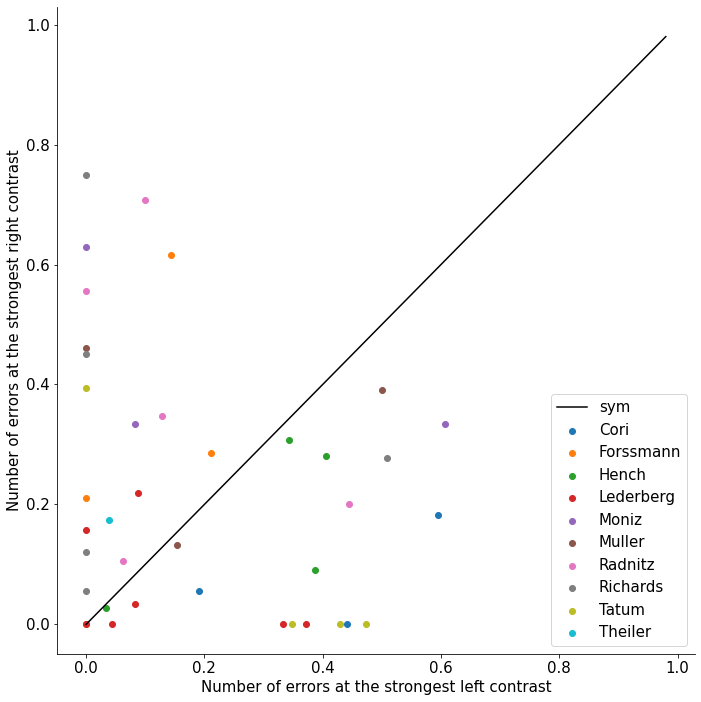

In [ ]:
fig, ax = plt.subplots()
for key in mice.keys():
  n = len(mice[key]['responses'])
  vec_err_l = np.zeros(n)
  vec_err_r = np.zeros(n)
  for i in range(n):
    vec_err_l[i] = 1 -  mice[key]['responses'][i][0,3,0] / np.sum (mice[key]['responses'][i][0,3,:])
    vec_err_r[i] = 1 -  mice[key]['responses'][i][3,0,2] / np.sum (mice[key]['responses'][i][3,0,:])
  mice[key]['vec_err_l'] = vec_err_l
  mice[key]['vec_err_r'] = vec_err_r

  ax.scatter(vec_err_l, vec_err_r, label = key)
  
line_x = np.arange(50)/50
line_y = np.arange(50)/50

ax.plot(line_x, line_y, 'k',label = 'sym')
ax.set_xlabel("Number of errors at the strongest left contrast")
ax.set_ylabel("Number of errors at the strongest right contrast")  
legend  = ax.legend()

plt.savefig("Strongest_contrast.pdf")
files.download("Strongest_contrast.pdf")

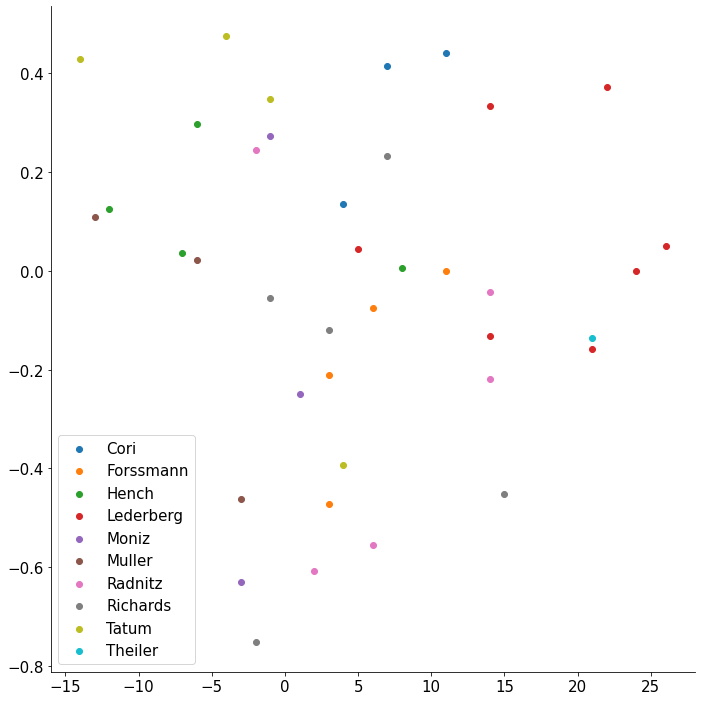

In [ ]:
fig, ax = plt.subplots()
for key in mice.keys():
  n = len(mice[key]['responses'])
  vec_0_l = mice[key]['vec_0_l']
  vec_0_r = mice[key]['vec_0_r']
  vec_err_l = mice[key]['vec_err_l']
  vec_err_r = mice[key]['vec_err_r']
  diff_0 = vec_0_l - vec_0_r
  diff_err = vec_err_l - vec_err_r
  
  mice[key]['diff_0'] = diff_0
  mice[key]['diff_err'] = diff_err

  ax.scatter(diff_0, diff_err, label = key)
  
#line_x = np.arange(50)/50
#line_y = np.arange(50)/50

#ax.plot(line_x, line_y, 'k',label = 'sym')
  
legend  = ax.legend()

plt.show()

In [ ]:
from scipy.optimize import LinearConstraint

linear_constraint = LinearConstraint([[1, 0, 0, 1, 0, 0, 1, 0 , 0], [0 ,1, 0, 0, 1, 0, 0, 1, 0 ], [ 0, 0, 1, 0, 0, 1, 0 , 0, 1]], [1, 1, 1],  [1,1,1])

In [ ]:
linear_constraint_2 = LinearConstraint([[0,0,0,0,0,1, 0, 0, 1, 0, 0, 1, 0 , 0], [0,0,0,0,0, 0 ,1, 0, 0, 1, 0, 0, 1, 0 ], [ 0, 0,0,0,0, 0, 0, 1, 0, 0, 1, 0 , 0, 1]], [1, 1, 1],  [1,1,1])

In [ ]:
from scipy.optimize import minimize

dat = alldat[25]
vec_left = dat['contrast_left']
vec_right = dat['contrast_right']
response = dat['response']

frequency = frequency_matr(vec_left, vec_right)
real_probs = real_results(vec_left, vec_right, response)



x0 = np.random.rand(14)
bounds = [(0,100), (-100,100), (-100,100), (-100,100), (-100,100), (0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)]
res = minimize(linear_discrepancy_as_func, x0, method='trust-constr', args = (real_probs, frequency),
               constraints=[linear_constraint_2], 
               options={'verbose': 2, 'maxiter':1000}, bounds=bounds) 

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  15   |   0   | +1.2895e+02 | 1.00e+00 | 1.23e+01 | 6.76e-01 |
|   2   |  30   |   1   | +1.1834e+02 | 7.00e+00 | 8.27e+00 | 6.76e-01 |
|   3   |  45   |   5   | +1.5907e+02 | 1.11e+01 | 2.00e+00 | 2.55e-01 |
|   4   |  60   |   9   | +1.9056e+02 | 1.19e+01 | 7.97e-01 | 2.22e-16 |
|   5   |  75   |  15   | +1.8990e+02 | 1.19e+01 | 9.47e-01 | 2.22e-16 |
|   6   |  90   |  21   | +1.8883e+02 | 1.19e+01 | 1.24e+00 | 2.22e-16 |
|   7   |  105  |  29   | +1.8665e+02 | 1.19e+01 | 3.48e+00 | 2.22e-16 |
|   8   |  120  |  38   | +1.8412e+02 | 1.19e+01 | 5.37e+00 | 4.44e-16 |
|   9   |  135  |  46   | +1.8272e+02 | 1.19e+01 | 5.71e+00 | 2.22e-16 |
|  10   |  150  |  51   | +1.8158e+02 | 1.19e+01 | 5.76e+00 | 1.11e-16 |
|  11   |  165  |  56   | +1.8034e+02 | 1.19e+01 | 5.79e+00 | 1.11e-16 |
|  12   |  180  |  61   | +1.7896e+02 | 1.19e+01 | 

/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


|  129  | 1650  |  666  | +1.1099e+02 | 1.00e-01 | 1.91e-06 | 2.22e-16 |
|  130  | 1650  |  667  | +1.1099e+02 | 1.00e-02 | 1.91e-06 | 2.22e-16 |
|  131  | 1650  |  668  | +1.1099e+02 | 1.00e-03 | 1.91e-06 | 2.22e-16 |
|  132  | 1650  |  669  | +1.1099e+02 | 1.00e-04 | 1.91e-06 | 2.22e-16 |
|  133  | 1650  |  670  | +1.1099e+02 | 1.00e-05 | 1.91e-06 | 2.22e-16 |
|  134  | 1650  |  671  | +1.1099e+02 | 1.00e-06 | 1.91e-06 | 2.22e-16 |
|  135  | 1650  |  672  | +1.1099e+02 | 1.00e-07 | 1.91e-06 | 2.22e-16 |
|  136  | 1650  |  673  | +1.1099e+02 | 1.00e-08 | 1.91e-06 | 2.22e-16 |
|  137  | 1665  |  674  | +1.1099e+02 | 5.00e-09 | 1.91e-06 | 2.22e-16 |
|  138  | 1680  |  674  | +1.1099e+02 | 1.00e+00 | 1.91e-06 | 2.22e-16 |
|  139  | 1695  |  675  | +1.1099e+02 | 1.00e-01 | 1.91e-06 | 2.22e-16 |
|  140  | 1695  |  676  | +1.1099e+02 | 1.00e-02 | 1.91e-06 | 2.22e-16 |
|  141  | 1695  |  677  | +1.1099e+02 | 1.00e-03 | 1.91e-06 | 2.22e-16 |
|  142  | 1695  |  678  | +1.1099e+02 | 1.00e-04 | 

In [ ]:
inputvec = res.x

energy_loss = inputvec[0]
print('energy_loss =', energy_loss)
A = inputvec[1:5].reshape(2,2)
print('cov_matrix = ', A)
pmatr = inputvec[5:].reshape(3,3)
print('decision randomization = ', pmatr)
likel = analytical_linear_choice(A, frequency, energy_loss)
print('resulting probabilities = ', likel)
lgl = - mat_loglikelihood(likel, pmatr)
print('real probabilies = ', real_probs)
disc = np.sum(real_probs * lgl)
print(likel)


energy_loss = 3.4680063995693066e-10
cov_matrix =  [[17.2360385  -9.58480607]
 [ 1.10882741  0.6025313 ]]
decision randomization =  [[9.82270861e-01 1.68904696e-01 1.87310022e-02]
 [1.77291368e-02 6.63920743e-01 3.20415425e-01]
 [1.80519836e-09 1.67174561e-01 6.60853573e-01]]
resulting probabilities =  [[[1.14672479e-01 8.84852938e-01 4.74582989e-04]
  [9.72977743e-01 2.70222552e-02 1.72177507e-09]
  [9.99999997e-01 2.61258226e-09 1.16778159e-21]
  [9.99999997e-01 2.80593243e-09 1.70886442e-59]]

 [[2.12891906e-01 7.14957407e-08 7.87108023e-01]
  [3.58767081e-01 2.88026990e-01 3.53205929e-01]
  [3.36389438e-01 6.63518702e-01 9.18600033e-05]
  [9.99999997e-01 3.03711364e-09 1.44727129e-24]]

 [[2.90710339e-02 5.80866963e-09 9.70928960e-01]
  [4.35053788e-02 1.82054935e-08 9.56494603e-01]
  [3.51447731e-01 1.48380753e-06 6.48550786e-01]
  [7.22406394e-01 2.77583686e-01 9.91983773e-06]]

 [[9.76903007e-42 2.28498789e-09 9.99999998e-01]
  [1.72641739e-23 1.20734034e-08 9.99999988e-01]
  [3

In [ ]:
dat = alldat[25]
vec_left = dat['contrast_left']
vec_right = dat['contrast_right']
response = dat['response']
n_sigmas = 100
eta = 0
n_energies = 1
sigmas = np.arange(n_sigmas) / 50 +0.02
energies = np.arange(n_energies) / 10 +0.0
n_eps = 20
epsilons = np.arange(n_eps) / 50
n_trials = 50000
discr = np.zeros(n_sigmas * n_energies).reshape(n_sigmas, n_energies)
F = frequency_matr(vec_left, vec_right)
R = real_results(vec_left, vec_right, response)
likes =  np.zeros(48 * n_sigmas * n_energies).reshape(n_sigmas, n_energies, 4,4,3)

for i in range(n_sigmas):
  print('sigma = ', sigmas[i])
  for j in range(n_energies):
    print('energy = ', energies[j])
    likes[i,j,:,:,:] = liklihood_corr(sigmas[i],eta,  F, n_trials, energies[j])
  


#for i in range(n_sigmas):
#  for j in range(n_eps):
#    L = linear_loglikelihood(likes[i,:,:,:], eps[j])
#    discr[i,j] = np.sum(R * L)
  

#print(np.argmax(discr))
#print(sigmas[int(np.argmax(discr))])
#plt.plot(sigmas, thresh)


sigma =  0.02
energy =  0.0
sigma =  0.04
energy =  0.0
sigma =  0.06
energy =  0.0
sigma =  0.08
energy =  0.0
sigma =  0.1
energy =  0.0
sigma =  0.12000000000000001
energy =  0.0
sigma =  0.13999999999999999
energy =  0.0
sigma =  0.16
energy =  0.0
sigma =  0.18
energy =  0.0
sigma =  0.19999999999999998
energy =  0.0
sigma =  0.22
energy =  0.0
sigma =  0.24
energy =  0.0
sigma =  0.26
energy =  0.0
sigma =  0.28
energy =  0.0
sigma =  0.30000000000000004
energy =  0.0
sigma =  0.32
energy =  0.0
sigma =  0.34
energy =  0.0
sigma =  0.36000000000000004
energy =  0.0
sigma =  0.38
energy =  0.0
sigma =  0.4
energy =  0.0
sigma =  0.42000000000000004
energy =  0.0
sigma =  0.44
energy =  0.0
sigma =  0.46
energy =  0.0
sigma =  0.48000000000000004
energy =  0.0
sigma =  0.5
energy =  0.0
sigma =  0.52
energy =  0.0
sigma =  0.54
energy =  0.0
sigma =  0.56
energy =  0.0
sigma =  0.5800000000000001
energy =  0.0
sigma =  0.6
energy =  0.0
sigma =  0.62
energy =  0.0
sigma =  0.64
ene

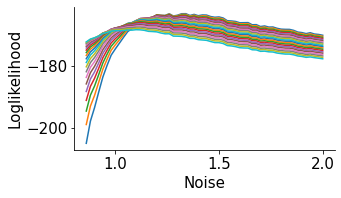

In [ ]:
rcParams['figure.figsize'] = [5, 3]
rcParams['font.size'] =15
my_disc = np.zeros(n_sigmas * n_eps).reshape(n_sigmas, n_eps)

for i in range(n_sigmas):
  for j in range(n_eps):
    L = linear_loglikelihood(likes[i,0,:,:], epsilons[j])
    my_disc[i,j] = np.sum(R * L)
  
ax = plt.subplot(1,1,1)
#print(np.argmax(discr))
#print(sigmas[int(np.argmax(discr))])
for i in range(n_eps):
  plt.plot(sigmas[42:], my_disc[42:,i])
#plt.plot(sigmas, thresh)

ax.set(xlabel  = 'Noise', ylabel = 'Loglikelihood');

In [ ]:
from scipy.optimize import minimize
real_probs = R

x0 = np.random.rand(9)
bounds = [(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)]
res = minimize(matr_discrepancy_as_func, x0, method='trust-constr', args = (likes, real_probs),
               constraints=[linear_constraint], 
               options={'verbose': 2}, bounds=bounds)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  10   |   0   | +6.4825e+01 | 1.00e+00 | 4.50e+00 | 1.04e+00 |
|   2   |  20   |   1   | +6.4825e+01 | 5.00e-01 | 4.50e+00 | 1.04e+00 |
|   3   |  30   |   3   | +9.9460e+01 | 3.03e+00 | 5.28e-01 | 6.71e-01 |
|   4   |  40   |   5   | +1.5997e+02 | 1.18e+01 | 4.37e+00 | 2.00e-01 |
|   5   |  50   |   7   | +1.9362e+02 | 1.18e+01 | 3.55e+00 | 0.00e+00 |
|   6   |  60   |   9   | +1.9099e+02 | 1.18e+01 | 6.15e-01 | 0.00e+00 |
|   7   |  80   |  11   | +1.9099e+02 | 1.18e+00 | 6.15e-01 | 0.00e+00 |
|   8   |  90   |  12   | +1.9087e+02 | 1.18e+00 | 5.54e-02 | 2.22e-16 |
|   9   |  100  |  14   | +1.9087e+02 | 1.18e+00 | 1.87e-02 | 2.22e-16 |
|  10   |  100  |  14   | +1.9087e+02 | 5.91e+00 | 3.90e-03 | 2.22e-16 |
|  11   |  100  |  14   | +1.9087e+02 | 2.96e+01 | 5.02e-03 | 2.22e-16 |
|  12   |  110  |  17   | +1.9087e+02 | 2.96e+01 | 

In [ ]:
print(res.x.reshape(3,3))

matr_discrepancy_as_func(res.x, likes, real_probs)

[[9.99999966e-01 3.41422339e-07 4.00132667e-09]
 [1.22695095e-08 7.77644586e-01 1.21255395e-07]
 [2.14889202e-08 2.22355072e-01 9.99999875e-01]]


143.58631985978707

In [ ]:
pmatr = np.eye(3)
real_probs = R
a,b,c,d,e = likes.shape
real_probs = R
disc = np.zeros(a*b).reshape(a,b)
for i in range(a):
  for j in range(b):
    likel = likes[i,j,:,:]
    lgl = - mat_loglikelihood(likel, pmatr)
    disc[i,j] = np.sum(real_probs * lgl)


In [ ]:
i, j  = np.unravel_index(np.argmin(disc, axis=None), disc.shape)

print(sigmas[i])
print(energies[j])
#print(epsilons[k])
print(i)
print(j)
#print(k)
disc[i,j]

0.8
0.2
39
2


145.5347477793598

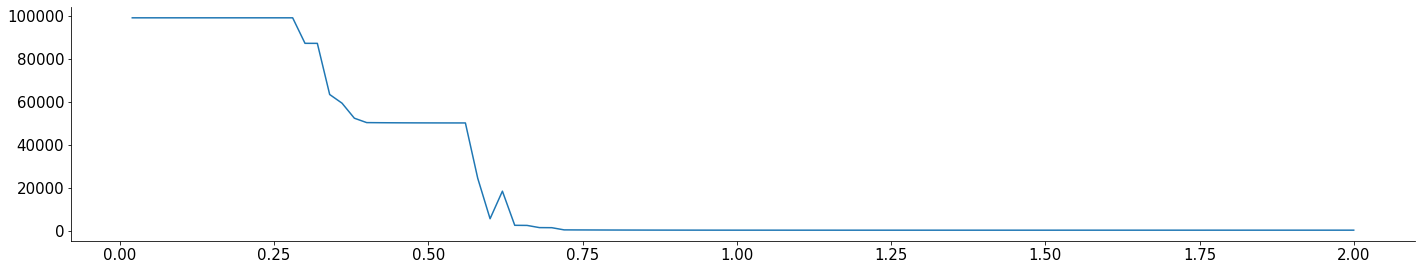

In [ ]:
for i in range(n_energies):

  plt.plot(sigmas,disc)

In [ ]:
# Plot as 16 separate curves
mes_regions=['VISam', 'VISp']
unique_r_vals=np.unique(dat['contrast_right'])
unique_l_vals=np.unique(dat['contrast_left'])

# Plotting with moving average filter
i=1
for reg in visual_areas:
  plt.figure(figsize=[20, 400])
  vis_list =  vis_dict[reg]
  for j in range (len(vis_list)):
    trial, mouse = vis_list[j]

    for con_l in unique_l_vals:
        for con_r in unique_r_vals:
          plt.subplot(148, 4, i)
          ts=1/dt * alldat[trial]['spks'][alldat[trial]['brain_area']==reg][:, (alldat[trial]['contrast_right']==con_r) & (alldat[trial]['contrast_left']==con_l)].mean(axis=(0,1))
          plt.plot(ts);
          plt.ylim([0, 10])
          i=i+1
          plt.title(str(i) + ' ' +  reg + ' ' +str(con_l)+' '+str(con_r) + ' \n' + str(trial) + mouse)

NameError: ignored

In [ ]:
visual_areas = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]

vis_dict = {}

for v in visual_areas:
  vis_dict[v] = []

tot = 0
for i in range(len(alldat)):
  for v in visual_areas:
    if (v in alldat[i]['brain_area']):
      #print(i)
      #print(v)
      vis_dict[v].append((i, alldat[i]['mouse_name']))
      tot += 1

print(vis_dict)
#print(tot)



{'VISa': [(3, 'Forssmann'), (4, 'Forssmann'), (7, 'Hench'), (19, 'Moniz'), (29, 'Richards')], 'VISam': [(2, 'Cori'), (8, 'Hench'), (11, 'Lederberg'), (12, 'Lederberg'), (18, 'Moniz'), (22, 'Muller'), (26, 'Radnitz'), (34, 'Tatum'), (35, 'Tatum'), (36, 'Tatum'), (38, 'Theiler')], 'VISl': [(1, 'Cori'), (8, 'Hench'), (9, 'Hench')], 'VISp': [(0, 'Cori'), (2, 'Cori'), (3, 'Forssmann'), (7, 'Hench'), (9, 'Hench'), (11, 'Lederberg'), (13, 'Lederberg'), (19, 'Moniz'), (21, 'Muller'), (24, 'Radnitz'), (25, 'Radnitz'), (38, 'Theiler')], 'VISpm': [(1, 'Cori'), (18, 'Moniz'), (23, 'Muller'), (27, 'Radnitz')], 'VISrl': [(9, 'Hench'), (23, 'Muller')]}


ValueError: ignored

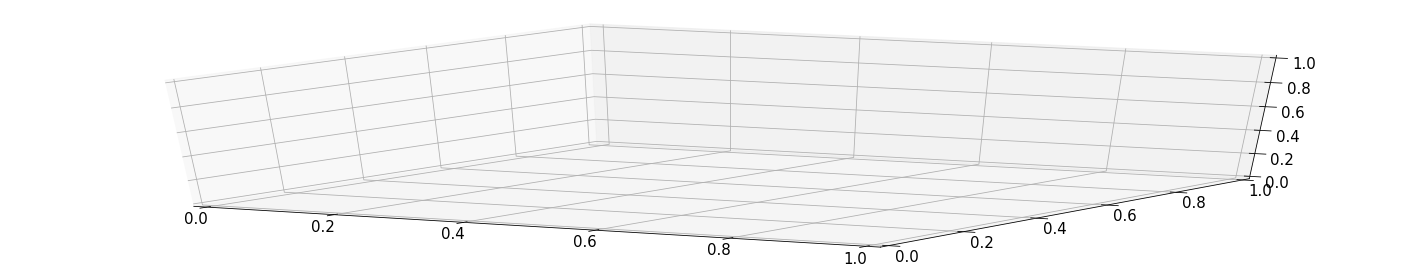

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = sigmas
Y = epsilons
X, Y = np.meshgrid(X, Y)
#R = np.sqrt(X**2 + Y**2)
Z = discr

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

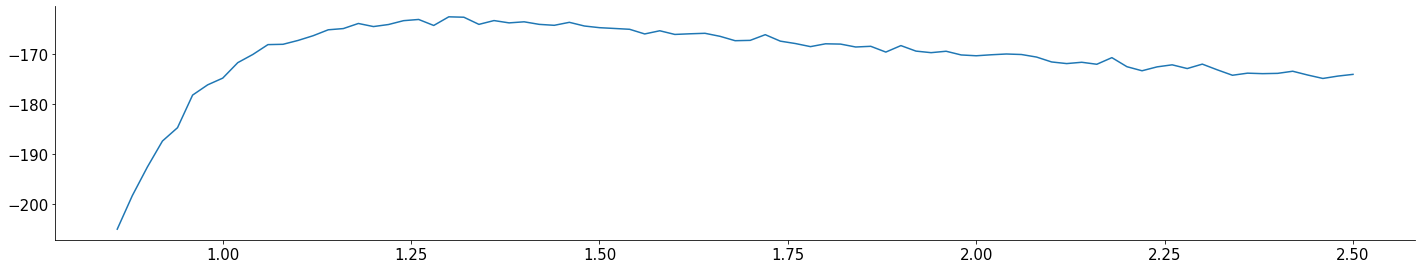

In [ ]:
plt.plot(sigmas[17:], discr[17:])

In [ ]:
import numpy as np
import numba as nb
from scipy import integrate
from numba import jit

@jit(nopython=True)
def decision(x,y,thresh):
  if (max(x,y) < thresh):
    return(0)
  elif (x > y):
    return(1)
  else:
    return(-1)  

@jit(nopython=True)
def reward(response, l, r):
  if ((r==0) and (l == 0) and (response == 0)):
    theor_rew = 1
  elif ((r==0) and (l == 0)):
    theor_rew = -1
  elif  ((r== l) and (response == 0)):
    theor_rew = -1
  elif  ((r== l)):
    theor_rew = 2*np.random.randint(2) - 1
  elif  ((r > l) and (response == -1)):
    theor_rew = 1
  elif ((r > l)):
    theor_rew = -1
  elif  ((r < l) and (response == 1)):
    theor_rew = 1
  elif ((r < l)):
    theor_rew = -1

  return (theor_rew)

@jit(nopython=True)
def gain(left, right, noise_level, eps, thresh):
  #print(noise_level)
  #a = np.random.normal(0,noise_level)
  l = left + np.random.normal(0,noise_level)
  r = right + np.random.normal(0,noise_level)
  response = decision(l,r,thresh)
  g =  reward(response,left,right) - eps * response**2
  return (g)

@jit(nopython=True)
def analytical_gain(left, right, noise_left, noise_right, eps, thresh):
  #print(noise_level)
  #a = np.random.normal(0,noise_level)
  l = left + noise_left
  r = right + noise_right
  response = decision(l,r,thresh)
  g =  reward(response,left,right) - eps * response**2
  return (g)

from scipy.integrate import quad, dblquad

#jit(nopython=True)
def my_integral(left, right, noise_level, eps, thresh, n_trials):
 # print(eps)
  def integrand(y,x):
   return ( np.exp(- (x**2 + y**2) / (2*noise_level**2)) / (noise_level**2 * 2 * np.pi ) * analytical_gain(left, right, x, y, eps, thresh)  )
  integr, err = integrate.dblquad(integrand, -np.inf, np.inf, -np.inf, np.inf)
  return integr




@jit(nopython=True)
def average_gain(left, right, noise_level, eps, thresh, n_trials):
  av_g = 0
  for i in range(n_trials):
    av_g += gain(left, right, noise_level, eps, thresh)
  av_g = av_g / n_trials
  return (av_g)

@jit(nopython=True)
def gain_matrix(noise_level, eps, thresh, n_trials):
  G = np.zeros(16).reshape(4,4)
  contrast = [0,0.25, 0.5, 1]
  for i in range(4):
    for j in range(4):
      G[i,j] = average_gain(contrast[i], contrast[j], noise_level, eps, thresh, n_trials)
  return G

#@jit(nopython=True)
def an_gain_matrix(noise_level, eps, thresh,n_trials):
  G = np.zeros(16).reshape(4,4)
  n_trials = 1
  contrast = [0,0.25, 0.5, 1]
  for i in range(4):
    for j in range(4):
      G[i,j] = my_integral(contrast[i], contrast[j], noise_level, eps, thresh, n_trials)
  return G



@jit(nopython=True)
def total_gain( thresh,  vec_left, vec_right, noise_level, eps, n_trials):
  ind_left = contrast_to_index(vec_left)
  ind_right = contrast_to_index(vec_right)
  G = gain_matrix(noise_level, eps, thresh, n_trials)
  tot = 0
  for i in range(len(vec_left)):
    tot += G[int(ind_left[i]), int(ind_right[i])] 
  return (tot)


#@jit(nopython=True)
def an_total_gain( thresh,  vec_left, vec_right, noise_level, eps, n_trials):
  ind_left = contrast_to_index(vec_left)
  ind_right = contrast_to_index(vec_right)
  G = an_gain_matrix(noise_level, eps, thresh, n_trials)
  tot = 0
  for i in range(len(vec_left)):
    tot += G[int(ind_left[i]), int(ind_right[i])] 
  return (tot)


#jit(nopython=True)
def loss(thresh,  vec_left, vec_right, noise_level, eps, n_trials):
  lo =  0 - total_gain( thresh,  vec_left, vec_right, noise_level, eps, n_trials)
  return lo

#@jit(nopython=True)
def my_moving_window(x, window=7, FUN=np.mean):
  """
  Calculates a moving estimate for a signal

  Args:
      x (numpy.ndarray): a vector array of size N
      window (int): size of the window, must be a positive integer
      FUN (function): the function to apply to the samples in the window

  Returns:
      (numpy.ndarray): a vector array of size N, containing the moving
      average of x, calculated with a window of size window

  There are smarter and faster solutions (e.g. using convolution) but this
  function shows what the output really means. This function skips NaNs, and
  should not be susceptible to edge effects: it will simply use
  all the  available samples, which means that close to the edges of the
  signal or close to NaNs, the output will just be based on fewer samples. By
  default, this function will apply a mean to the samples in the window, but
  this can be changed to be a max/min/median or other function that returns a
  single numeric value based on a sequence of values.
  """

 
  

  # make output array of the same size as x:
  output = np.zeros(x.size)

  # loop through the signal in x
  for samp_i in range(x.size):

    values = []

    # loop through the window:
    for wind_i in range(int(1 - window), 1):

      if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
        # out of range
        continue

      # sample is in range and not nan, use it:
      if not(np.isnan(x[samp_i + wind_i])):
        values += [x[samp_i + wind_i]]

    # calculate the mean in the window for this point in the output:
    output[samp_i] = FUN(values)

  return output


#@jit(nopython=True)
def optimal( noise_level,  vec_left, vec_right, eps, n_trials, step_threshold, initial_threshold):
  thresholds = (np.arange(40) - 10) *step_threshold +  initial_threshold
  gains = np.zeros(40)
  for i in range(40):
    gains[i] = total_gain( thresholds[i],  vec_left, vec_right, noise_level, eps, n_trials)
  g = my_moving_window(gains)
  t = my_moving_window(thresholds)
  j = np.argmax(g)

  return (t[j] , g[j])

#@jit(nopython=True)
def an_optimal( noise_level,  vec_left, vec_right, eps, n_trials, step_threshold, initial_threshold):
  thresholds = (np.arange(40) - 10) *step_threshold +  initial_threshold
  gains = np.zeros(40)
  for i in range(40):
    gains[i] = an_total_gain( thresholds[i],  vec_left, vec_right, noise_level, eps, n_trials)
  g = my_moving_window(gains)
  t = my_moving_window(thresholds)
  j = np.argmax(g)

  return (t[j] , g[j])



#@jit(nopython=True)
def my_optimal_mouse(noise_level, eps, thresh, n_trials):
  resp_prob_table = np.zeros(48).reshape(4,4,3)
  contrast = [0,0.25, 0.5, 1]
  for i in range(4):
    for j in range(4):
      for k in range(n_trials):
        l = contrast[i] + np.random.normal(0,noise_level)
        r = contrast[j] + np.random.normal(0,noise_level)
        response = decision(l,r,thresh)
        resp_prob_table[i,j, int(response)+1] += 1
  resp_prob_table /= n_trials
  return (resp_prob_table)

#@jit(nopython=True)
def real_mouse_results(vec_left, vec_right, response):
  resp_prob_table = np.zeros(48).reshape(4,4,3)
  ind_left = contrast_to_index(vec_left)
  ind_right = contrast_to_index(vec_right)
  for k in range(len(vec_left)):

    resp_prob_table[int(ind_left[k]),int(ind_right[k]), int(response[k])+1] += 1
  resp_prob_table /= n_trials
  return (resp_prob_table)

def gonogo_real(vec_left, vec_right, response):
  allres = real_mouse_results(vec_left, vec_right, response)
  p = allres[:,:,1]
  res = np.zeros(32).reshape(4,4,2)
  res[:,:,0] = p
  res[:,:,1] = 1 - p
  return(res)


def gonogo(A):
  p = A[:,:,1]
  res = np.zeros(32).reshape(4,4,2)
  res[:,:,0] = A[:,:,1]
  res[:,:,1] = A[:,:,0] + A[:,:,2]
  return(res)

#@jit(nopython=True)
def discrepancy(noise_level, vec_left, vec_right, response,  eps, n_trials, step_threshold, initial_threshold):
  F = frequency_matr(vec_left, vec_right)
  thresh, g  = optimal( noise_level,  vec_left, vec_right, eps, n_trials, step_threshold, initial_threshold)
  A = my_optimal_mouse(noise_level, eps, thresh, n_trials)
  B = real_mouse_results(vec_left, vec_right, response) 
  #for i in range(3):
   # A[:,:,i] /= F
  #  B[:,:,i] /= F


  return (np.sum(B * np.log(A)), thresh)


def discrepancy_gonogo(noise_level, vec_left, vec_right, response,  eps, n_trials, step_threshold, initial_threshold):
  F = frequency_matr(vec_left, vec_right)
  thresh, g  = optimal( noise_level,  vec_left, vec_right, eps, n_trials, step_threshold, initial_threshold)
  A = gonogo_semi_analit(noise_level, eps, thresh, n_trials)
  B = gonogo_real(vec_left, vec_right, response) 
  print('A = ' ,A)
  print('B = ',B)
  #for i in range(3):
  #  A[:,:,i] /= F
  #  B[:,:,i] /= F


  return (np.sum(B * np.log(A)), thresh)

#@jit(nopython=True)
def an_discrepancy(noise_level, vec_left, vec_right, response,  x0):
  F = frequency_matr(vec_left, vec_right)
  sigma = noise_level 
  eps = 0
  n_trials = 10000
  thresh  = optimal_threshold(F, sigma, x0)
  A = my_optimal_mouse(noise_level, eps, thresh, n_trials)
  B = real_mouse_results(vec_left, vec_right, response) 
  #for i in range(2):
  #  A[:,:,i] /= F
  #  B[:,:,i] /= F


  return (np.sum(B * np.log(A)), thresh)


def discrepancy_gonogo_semianalit(noise_level, vec_left, vec_right, response,  x0):
  F = frequency_matr(vec_left, vec_right)
  sigma = noise_level 
  eps = 0
  n_trials = 10000
  thresh  = optimal_threshold(F, sigma, x0)
  A = my_optimal_mouse(noise_level, eps, thresh, n_trials)
  B = real_mouse_results(vec_left, vec_right, response) 

  A1 = gonogo(A)
  B1 = gonogo(B)

  for i in range(4):
    for j in range(4):
      if (B1[i,j,1] * np.log(A1[i,j,1]) < B[i,j,0] * np.log(A[i,j,0]) + B[i,j,2] * np.log(A[i,j,2])   ):
        print(B1[i,j,1], A1[i,j,1] , B[i,j,0] , A[i,j,0] , B[i,j,2] , A[i,j,2] )




  #for i in range(2):
  #  A[:,:,i] /= F
  #  B[:,:,i] /= F


  return (np.sum(B1 * np.log(A1)), thresh)


#@jit(nopython=True)
def an_discrepancy_gonogo(noise_level, vec_left, vec_right, response,  x0):
  F = frequency_matr(vec_left, vec_right)
  sigma = noise_level 
  eps = 0
  n_trials = 10000
  thresh  = optimal_threshold(F, sigma, x0)
  if (sigma == 1):
    print('t = ', thresh)
  #print('t= ' , thresh)
  #print('sigma =' , sigma)
  A = gonogo_theor(thresh, sigma)
  
  #print('A = ' ,A)
  B2 = real_mouse_results(vec_left, vec_right, response) 

  B = gonogo(B2)

  A1 = A.reshape(32)
  B1 = B.reshape(32)
  s = 0
  for i in range(32):
    if B1[i] == 0:
      pass
    elif A1[i] == 0:
      s -= 100000
    else:
      s +=  B1[i] * np.log(A1[i]) 
  return (s, thresh)



In [ ]:
testvec = [1,2,3,4,5]
testvec[1:3]

[2, 3]

In [ ]:
import math
#@jit(nopython=True)


#@jit(nopython=True)
def my_function(t , F, sigma):
  contrast = [0,0.25, 0.5, 1]
  f = np.exp(-t**2 / (2*sigma**2)) * (math.erf(t / sigma) + 0.5) * F[0,0]

  for i in range(1,4):
    f += - 2 * np.exp(-(t- contrast[i])**2 / (2*sigma**2)) * (math.erf((t - contrast[i]) / sigma) + 1) * F[i,i]
                     
  for i in range(1,4):

    for j in range(1,i):
      f -= np.exp(-(t- contrast[i])**2 / (2*sigma**2)) * (math.erf((t - contrast[j]) / sigma) + 1) * F[i,j] / 2
      f -= np.exp(-(t- contrast[j])**2 / (2*sigma**2)) * (math.erf((t - contrast[i]) / sigma) + 1) * F[j,i] / 2

  return (f)            

                        
#@jit(nopython=True)
def optimal_threshold(F, sigma, x0):
  #print(type(F))
  #print(type(sigma))
  #print(type(x0))
  sol = optimize.root(my_function, [x0], args = (F,sigma))
  #print(sol)
  #print(type(sol.x))
  #print(len(sol.x))
  #print(sol.x[0])
  return (sol.x[0])

#@jit(nopython=True)
def gonogo_theor(threshold, sigma):
  t = threshold
  resp_prob_table = np.zeros(32).reshape(4,4,2)
  contrast = [0,0.25, 0.5, 1]
  for i in range(4):
    for j in range(4):
      l = contrast[i] 
      r = contrast[j] 
      resp_prob_table[i,j,0] = (1 + math.erf((t-l)/sigma)) * (1 + math.erf((t-r)/sigma)) / 4
      resp_prob_table[i,j,1] = 1 - resp_prob_table[i,j,0]
  return (resp_prob_table)

In [ ]:
sigma = 1.0
threshold = 0.8574667297287579
optprob = gonogo_theor(threshold, sigma)
print(optprob)

print(np.sum(np.log(optprob)))

[[[0.78741924 0.21258076]
  [0.71420038 0.28579962]
  [0.61530717 0.38469283]
  [0.37280526 0.62719474]]

 [[0.71420038 0.28579962]
  [0.64778985 0.35221015]
  [0.55809231 0.44190769]
  [0.33813964 0.66186036]]

 [[0.61530717 0.38469283]
  [0.55809231 0.44190769]
  [0.48081492 0.51918508]
  [0.29131845 0.70868155]]

 [[0.37280526 0.62719474]
  [0.33813964 0.66186036]
  [0.29131845 0.70868155]
  [0.17650542 0.82349458]]]
-24.49704689686389


In [ ]:

F = frequency_matr(vec_left, vec_right)
#sigma = 0.1

#t = 0.2

print(F)
sigma = np.arange(1,101)/50 + 0.1
t = np.zeros(100)
x0 = 0.2
for i in range(100):
  t[i] = optimal_threshold( F, sigma[i], x0)
  x0 = t[i] 

plt.plot(sigma,t)

#sol = optimize.root(my_function, [1], args = (F,sigma))
#optimal_threshold(F, 0.02, 0.2 )
#print(sol)


NameError: ignored

In [ ]:

from scipy import optimize

vec_left = dat['contrast_left']
vec_right = dat['contrast_right']
response = dat['response']
noise_level = np.arange(1,101) / 40 +0.1
eps = 0
n_trials = 10000
discr = np.zeros(100)
thresholds  = np.zeros(100)
step_threshold = 0.01
initial_threshold = 0.2
#B = gonogo_real(vec_left, vec_right, response) 
#noise_level = 1.5
#tot_g = np.zeros(100)
#thresh = np.arange(100)/40 - 1.0
#print(B)
for i in range(100):
  #print('noise_level=', noise_level[i])
  #discrep, threshold = discrepancy_gonogo(noise_level[i], vec_left, vec_right, response,  eps, n_trials, step_threshold, initial_threshold)
  discrep, threshold =  discrepancy_gonogo_semianalit(noise_level[i], vec_left, vec_right, response,  initial_threshold)
  #discrep, threshold =  an_discrepancy_gonogo(noise_level[i], vec_left, vec_right, response,  initial_threshold)
  #tot_g[i] = total_gain( thresh[i],  vec_left, vec_right, noise_level, eps, n_trials)
  #print(discrep, threshold)
  initial_threshold = threshold
  thresholds[i] = threshold
  discr[i] = discrep
  
t = my_moving_window(thresholds)
d = my_moving_window(discr)
noi = my_moving_window(noise_level) 

#plt.plot(noise_level, thresholds)
#plt.plot(noise_level, discr)

#res = minimize(loss, x0,  args = (vec_left, vec_right, noise_level, eps, n_trials), tol = 0.01, options={'maxiter':1000} ) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:315: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:315: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:326: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:326: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


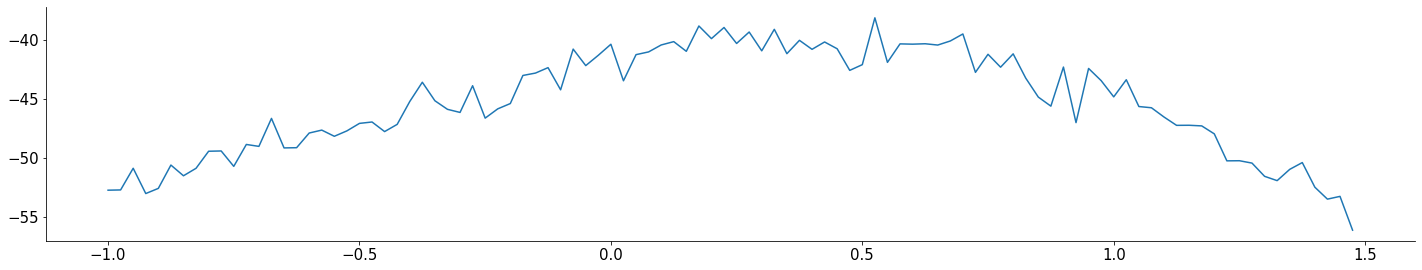

In [ ]:
plt.plot(thresh, tot_g)

In [ ]:
math.erf(5)

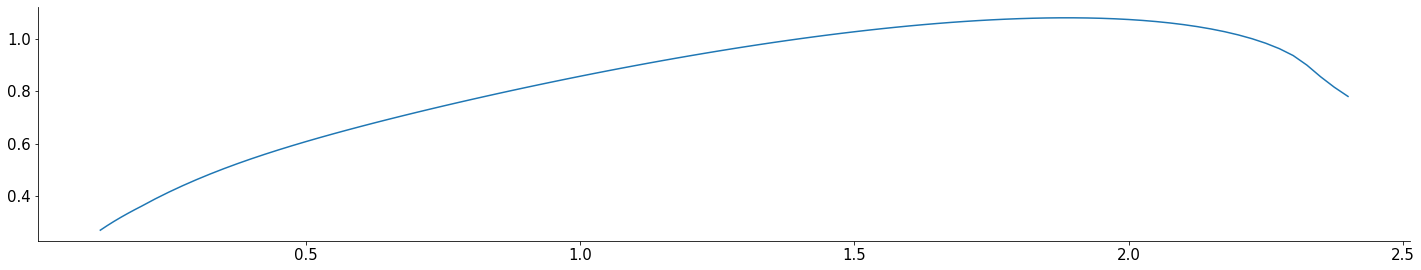

In [ ]:
plt.plot(noi[:-5], t[:-5])

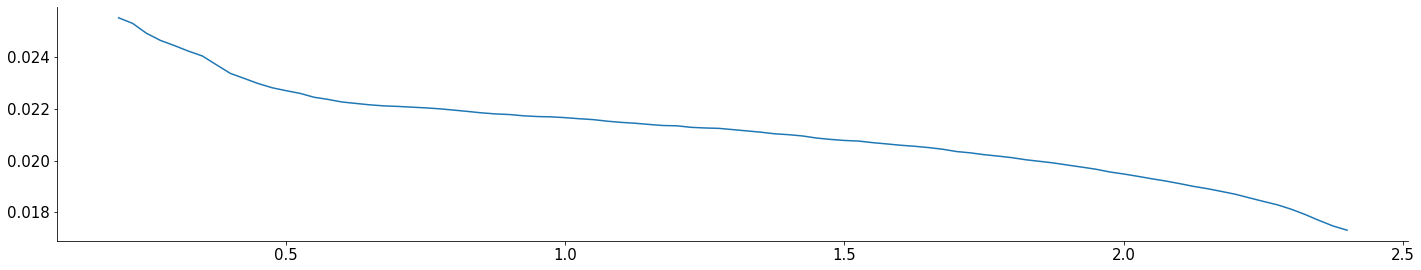

In [ ]:
plt.plot(noi[:-5], -d[:-5])
#ax.set(xlabel  = 'sigma of noise', ylabel = 'Log likelihood')

In [ ]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 12]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

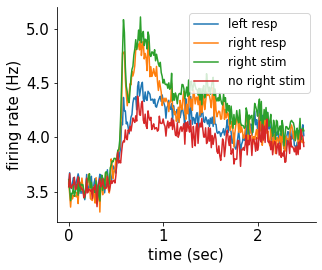

In [ ]:
#@title basic plots of population average
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [ ]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

In [ ]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


In [ ]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


In [ ]:
# plot the LFP

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
isort = np.argsort(-is_correct.astype('float32') + response/10) # sort by correct, and then by response

nwrong = np.sum(is_correct)
plt.figure(figsize=(20,6))
for j in range(len(dat['lfp'])):
  ax = plt.subplot(2,6,j+1)
  plt.imshow(dat['lfp'][j, isort], cmap = 'bwr', vmax = 50, vmin=-50, aspect='auto')
  plt.title('Area %s'%dat['brain_area_lfp'][j])
  
  plt.plot([0, NT], [nwrong, nwrong], 'r')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  


In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


In [ ]:
# plot the spike waveforms for some neurons. Sometimes these can tell us what cell type the neuron is 
# (i.e. fast spiking interneurons have short waveforms)

for j in range(7):
  ax = plt.subplot(1,7,j+1)
  kk = 140 + j * 50
  wav = dat['waveform_w'][kk] @ dat['waveform_u'][kk]
  plt.plot(wav)
  ax.set(xlabel = 'time samples', title ='unit %d'%kk, ylabel = 'normalized units')

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')